# Setup

In [1]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    read_data, # Data Ingestion
    filter_df, check_target_dependency, # EDA
    calculate_psi, run_chi_square_tests, # Validation
    train_lgbm, # Model Training
    clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    calc_intraday_gradient, 
    get_master_daily_target_data, generate_interday_target_features, 
    get_master_daily_price_data, generate_interday_price_features, 
    get_master_daily_volume_data, generate_interday_volume_features
)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%load_ext autoreload
%autoreload

In [4]:
DATA_DIR = '../data/'

## Read Data

In [5]:
%%time
master_df = read_data(f'{DATA_DIR}/optiver-train-data/clipped_train.parquet')
weight_df = read_data(f"{DATA_DIR}/optiver-support-data/stock_weight.csv")

CPU times: user 377 ms, sys: 245 ms, total: 621 ms
Wall time: 180 ms


In [6]:
missing_stock_dates = read_data(f"{DATA_DIR}/optiver-preprocess-helpers/missing_stock_dates.pkl")

In [7]:
missing_stock_dates

[(19, 438), (73, 320), (99, 138), (101, 328), (131, 35), (158, 388)]

In [8]:
base_columns = sorted(get_cols(master_df, contains=["price", "size"]))

In [9]:
# %%time
# revealed_targets = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
# test = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/test.csv')
# sample_submission = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

In [10]:
train = master_df.copy()

In [11]:
target_columns = get_cols(train, "target")
target_columns

['target', 'clipped_target', 'is_positive_target', 'is_mild_target']

In [12]:
del master_df
gc.collect()

95

# Interaction Features

In [13]:
def extract_triplets(df, triplet, suffix="_price"):
    triplet_col_prefix = "".join(sorted([col[0] for col in triplet])) #.replace(suffix, "")

    a = train[list(triplet)]
    min_, mid_, max_ = a.min(axis=1), a.median(axis=1), a.max(axis=1)
    
    return triplet_col_prefix, min_, mid_, max_

## Price Column Interaction

In [14]:
base_price_cols = get_cols(train, "price")
base_price_cols

['ref_price', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wa_price']

In [15]:
def generate_price_cross_sectional_features(train, base_price_cols):
    cprint(f"Generating 2 price columns' interaction features...", color="green")
    for p_col1, p_col2 in tqdm(combinations(base_price_cols, 2)):
        paired_col = "".join(sorted([p_col1[0], p_col2[0]]))

        train[f"{paired_col}_gap"] = train[p_col1] - train[p_col2]
        train[f"{paired_col}_price"] = (train[p_col1] + train[p_col2]) / 2
        train[f"{paired_col}_gm_ratio"] = train[f"{paired_col}_gap"] / train[f"{paired_col}_price"]
    
    cprint(f"Generating 3 price columns' interaction features...", color="green")
    for triplet in tqdm(combinations(base_price_cols, 3)):
        triplet_col_prefix, min_, mid_, max_ = extract_triplets(train, triplet)

        train[f'{triplet_col_prefix}_imb_ratio1'] = (1 + max_ - mid_) / (1 + mid_ - min_)
        train[f'{triplet_col_prefix}_imb_ratio2'] = min_ / max_
        
    return train

In [16]:
# df["bid_ask_price_ratio"] = df["bid_price"] / (df["ask_price"])
# for p_col1, p_col2 in tqdm(combinations(around_one_price_cols, 2), disable=not verbose):
#     p1 = p_col1.replace("_price", "")
#     p2 = p_col2.replace("_price", "")
#     if "_" not in p1 and "_" not in p2:
#         temp1 = (df[p_col1] - 1)
#         temp2 = (df[p_col2] - 1)
#         df[f'{p1}_{p2}_sc_product'] = (temp1 * temp2).astype(np.float32)
#         df[f'{p1}_{p2}_sc_ratio'] = (np.exp(temp1) / np.exp(temp2)).astype(np.float32)

In [17]:
train.shape

(5237760, 18)

In [18]:
train = generate_price_cross_sectional_features(train, base_price_cols=base_price_cols)

Generating 2 price columns' interaction features...


15it [00:00, 25.92it/s]


Generating 3 price columns' interaction features...


20it [00:40,  2.02s/it]


## Volume Column Interaction

In [19]:
base_vol_cols = get_cols(train, "size")
base_vol_cols

['imb_size', 'matched_size', 'bid_size', 'ask_size']

In [20]:
def generate_volume_cross_sectional_features(train, base_vol_cols):
    # Add another column for absolute imbalance volume
    train["jmb_size"] = train["imb_size"] * train["imb_flag"]
    final_base_vol_cols = base_vol_cols + ["jmb_size"]
    
    interaction_vol_columns = []
    cprint(f"Generating 2 volume (or log volume) columns' interaction features...", color="green")
    for v_col1, v_col2 in tqdm(combinations(final_base_vol_cols, 2)):
        paired_col = "".join(sorted([v_col1[0], v_col2[0]]))
        
        if paired_col == "ij" or paired_col[0] == paired_col[1]:
            continue
        
        train[f"{paired_col}_size_gap"] = train[v_col1] - train[v_col2]
        train[f"{paired_col}_size_total"] = train[v_col1] + train[v_col2]
        # train[f"{paired_col}_st_ratio"] = train[v_col1] / train[f"{paired_col}_size_total"] # Single Volume / Total Volume ratio
        # train[f"{paired_col}_gt_ratio"] = train[f"{paired_col}_size_gap"] / train[f"{paired_col}_size_total"] # Gap Volume / Total Volume ratio
        
        train[f"{paired_col}_log_size_gap"] = my_log(train[v_col1]) - my_log(train[v_col2])
        train[f"{paired_col}_log_size_total"] = my_log(train[v_col1]) + my_log(train[v_col2])
        
        if paired_col != "im":
            train[f"{paired_col}_log_st_ratio"] = my_log(train[v_col1]) / train[f"{paired_col}_log_size_total"] # Single Volume / Total Volume ratio
            train[f"{paired_col}_log_gt_ratio"] = train[f"{paired_col}_log_size_gap"] / train[f"{paired_col}_log_size_total"] # Gap Volume / Total Volume ratio
        
        interaction_vol_columns.extend(get_cols(train, startswith=paired_col))
            
    return train, interaction_vol_columns

In [21]:
# df["log_imb_matched_size_ratio"] = df["log_imb_size"] / df["log_matched_size"]
# df["sqrt_imb_matched_size_ratio"] = my_power(df["imb_size"] / df["matched_size"], 1/2)
# df["sqrt_abs_imb_matched_size_ratio"] = my_power(df["abs_imb_size"] / df["matched_size"], 1/2)
# df["log_bid_matched_size_ratio"] = df["log_bid_size"] / df["log_matched_size"]
# df["bid_ask_size_ratio"] = df["bid_size"] / (df["ask_size"])
# df["log_ask_matched_size_ratio"] = df["log_ask_size"] / df["log_matched_size"]
# df["log_bid_ask_diff_abs_imb_product"] = my_log(df["bid_ask_size_diff"] * df["abs_imb_size"])

In [22]:
%%time
train, interaction_vol_columns = generate_volume_cross_sectional_features(train, base_vol_cols=base_vol_cols)

Generating 2 volume (or log volume) columns' interaction features...


10it [00:03,  3.05it/s]

CPU times: user 2.32 s, sys: 790 ms, total: 3.11 s
Wall time: 3.3 s


In [23]:
train.shape

(5237760, 156)

## Price Volume Interaction

In [67]:
# if verbose:
#     cprint(f"{get_time_now()} Getting Price-Volume Interaction Features...", color="green")
# df["ask_sp_product"] = df["ask_size"] * df["ask_price"]
# df["bid_sp_product"] = df["bid_size"] * df["bid_price"]
# df["bid_ask_sp_product_diff"] = df["ask_sp_product"] - df["bid_sp_product"]

# Lag Features

## First of Differences

In [26]:
columns_to_lag = list_diff(train, META_COLUMNS + target_columns)
len(columns_to_lag)

149

In [28]:
columns_to_lag[:20]

['bfn_imb_ratio1',
 'fr_price',
 'ai_log_size_total',
 'am_log_size_gap',
 'fnr_imb_ratio1',
 'jm_size_total',
 'nr_gm_ratio',
 'fn_gm_ratio',
 'bf_gm_ratio',
 'ai_log_size_gap',
 'af_gm_ratio',
 'am_size_total',
 'am_log_size_total',
 'anw_imb_ratio1',
 'ask_size',
 'aj_log_gt_ratio',
 'afw_imb_ratio1',
 'ab_log_gt_ratio',
 'aj_size_gap',
 'bn_price']

In [26]:
def get_fod_sod(df, verbose=0):
    df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    
    cprint(f"Constructing First Order Diff Features...", color="blue")
    temp_df = df.groupby(["stock_id", "date_id"])[base_columns].diff(1).add_suffix("_fod")
    for col in tqdm(temp_df.columns, disable=not verbose):
        if col not in df.columns:
            df[col] = temp_df[col]
    
    cprint(f"Calculating Cumulative Averages...", color="blue")
    temp_df2 = df.groupby(["stock_id", "date_id"])[temp_df.columns].cumsum()
    temp_df2 = temp_df2.rename(columns={k: k.replace("_fod", "_cumavg") for k in temp_df2.columns})
    
    for col in tqdm(temp_df2.columns, disable=not verbose):
        if col not in df.columns:
            df[col] = temp_df2[col] / (df["seconds"] / 10 + 1)
            
    cprint(f"Calculating FOD spread & sum...", color="blue")
    for p_col1, p_col2 in tqdm(combinations(get_cols(df, endswith="_fod"), 2), disable=not verbose):
        p1 = p_col1.replace("_fod", "")
        p2 = p_col2.replace("_fod", "")
        df[f"{p1}_{p2}_fod_spread"] = df[p_col1] - df[p_col2]
        df[f"{p1}_{p2}_fod_sum"] = df[p_col1] + df[p_col2]
        df[f"{p1}_{p2}_fod_ratio"] = df[f"{p1}_{p2}_fod_spread"] / df[f"{p1}_{p2}_fod_sum"]

    return df

In [30]:
%%time
train = get_fod_sod(train)

CPU times: user 6.68 s, sys: 9.83 s, total: 16.5 s
Wall time: 24.8 s


In [27]:
# train.to_parquet("../train_all.parquet")
# train = read_data("../train_all.parquet")
# logp = pd.read_csv("../feature_logp_values.csv")
# logp2 = pd.read_csv("../feature_logp_values2.csv")

## Intraday Lag Ratio

In [28]:
train.shape

(5237760, 214)

In [29]:
train

,stock_id,date_id,target,clipped_target,is_positive_target,is_mild_target,jmb_size,im_size_gap,im_size_total,im_log_size_gap,...,matched_size_wa_price_fod_ratio,near_price_ref_price_fod_spread,near_price_ref_price_fod_sum,near_price_ref_price_fod_ratio,near_price_wa_price_fod_spread,near_price_wa_price_fod_sum,near_price_wa_price_fod_ratio,ref_price_wa_price_fod_spread,ref_price_wa_price_fod_sum,ref_price_wa_price_fod_ratio
0,0,0,-3.029704,-3.029704,0,1,3180602.750,-10199674.0,16560880.0,-1.436711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0.389814,0.389814,1,1,1299772.750,-13961334.0,16560880.0,-2.463117,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000322,0.000106,3.038245
2,0,0,4.220009,4.220009,1,1,1299772.750,-13961334.0,16560880.0,-2.463117,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000057,-0.000157,0.362946
3,0,0,5.450249,5.450249,1,0,1299772.750,-13961334.0,16560880.0,-2.463117,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000029,0.000457,-0.063380
4,0,0,3.169775,3.169775,1,1,1218204.375,-14124471.0,16560879.0,-2.533259,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000090,0.000554,0.162470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237755,199,480,-7.209778,-7.209778,0,0,2661783.500,-26631000.0,21307432.0,-31.786789,...,1.0,-0.000952,0.000952,-1.0,-0.000870,0.000870,-1.0,0.000082,0.001822,0.045014
5237756,199,480,-9.750128,-9.750128,0,0,2658917.500,-26631000.0,21313164.0,-31.785831,...,1.0,0.000000,0.000000,NaN,-0.000139,0.000139,-1.0,-0.000139,0.000139,-1.000000
5237757,199,480,3.629923,3.629923,1,1,1352558.875,-25330938.0,22625822.0,-31.110172,...,1.0,0.000952,-0.000952,-1.0,0.000992,-0.000992,-1.0,0.000040,-0.001944,-0.020603
5237758,199,480,4.760027,4.760027,1,0,1352558.875,-25330938.0,22625822.0,-31.110172,...,-1.0,0.000000,0.000000,NaN,-0.000011,0.000011,-1.0,-0.000011,0.000011,-1.000000


In [ ]:
def get_lag

In [5]:
num_lags = 4
if verbose:
    cprint(f"{get_time_now()} Getting Lag Features with max Lag={num_lags}...", color="green")
# Group by 'stock_id' and 'date_id' and apply lags to selected columns
for col in tqdm(columns_to_shift, disable=not verbose):
    for lag in range(1, num_lags + 1):
        df[f'{col}_l{lag}'] = df.groupby(['stock_id', 'date_id'])[col].shift(lag)

for col in tqdm(columns_to_shift, disable=not verbose):
    if col.endswith("_price"):
        df[f"{col}_l1_ratio"] = df[col] / df[f"{col}_l1"]
        df[f"{col}_l2_ratio"] = df[col] / df[f"{col}_l2"]
        df[f"{col}_l1_l2_ratio_diff"] = df[f"{col}_l1_ratio"] - df[f"{col}_l2_ratio"]
        df[f"{col}_l0_l3_ma2_diff"] = (df[col] + df[f"{col}_l1"]) / (df[f"{col}_l2"] + df[f"{col}_l3"])

        l0 = (df[col] - 1)
        l1 = (df[f"{col}_l1"] - 1)
        l2 = (df[f"{col}_l2"] - 1)
        l3 = (df[f"{col}_l3"] - 1)
        df[f"{col}_sc_l1_ratio"] = np.exp(l0) / np.exp(l1)
        df[f"{col}_sc_l2_ratio"] = np.exp(l0) / np.exp(l2)
        df[f"{col}_sc_l1_l2_ratio_diff"] = df[f"{col}_sc_l1_ratio"] - df[f"{col}_sc_l2_ratio"]
        df[f"{col}_sc_l0_l3_ma_ratio"] = np.exp(l0 + l1) / np.exp(l2 + l3)

    elif col.endswith("_size") and not col.startswith("log_"):
        df[f"{col}_l1_ratio"] = df[col] / (df[col] + df[f"{col}_l1"])
        df[f"{col}_l2_ratio"] = df[col] / (df[col] + df[f"{col}_l2"])
        df[f"{col}_l1_l2_ratio_diff"] = (df[f"{col}_l1_ratio"] + df[f"{col}_l2_ratio"]) / 2
        df[f"{col}_l0_l3_ma2_diff"] = (
            np.log1p(df[col] + df[f"{col}_l1"]) / (1 + np.log1p(df[f"{col}_l2"] + df[f"{col}_l3"]))
        )

In [9]:
train = train.drop(columns=logp.columns)

In [11]:
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 1.4 GB


0it [00:00, ?it/s]

After downcast: 	RAM used: 1.4 GB


In [12]:
feature_list = list_diff(train, logp.columns)
len(feature_list)

214

In [ ]:
# log_chi_square_p_df, log_chi_square_p_mean = run_chi_square_tests(train, feature_columns=feature_list)
# log_chi_square_p_df.drop(columns=get_cols(log_chi_square_p_df, "target"), errors="ignore").to_csv("../feature_logp_values3.csv", index=False)

In [31]:
logp = read_data("../feature_logp_values.csv")
logp2 = read_data("../feature_logp_values2.csv")

In [34]:
all_logp = pd.concat([logp, logp2], axis=1)

In [36]:
all_logp

,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,...,ai_log_size_gap,bid_size_fod,ask_price_matched_size_fod_ratio,ask_size_imb_size_fod_sum,far_price_imb_size_fod_spread,aj_log_st_ratio,date_id,ask_price_far_price_fod_sum,ai_log_gt_ratio,matched_size_ref_price_fod_sum
0,-389.206260,-164.646276,-10.817701,-40.486516,-102.830368,-51.217598,-38.801598,-38.025028,-41.471037,-35.987401,...,-32.186533,-9.631617,-3.098272,-38.687925,-6.795944,-64.996624,-461.578828,-15.126801,-67.950774,-39.355026
1,-50.908032,-46.439328,-5.142320,-23.760449,-46.011060,-17.359206,-16.469281,-39.869953,-165.731764,-55.210048,...,-106.610638,-30.635509,-1.459549,-18.960202,-2.460302,-76.437571,-255.998470,-3.202682,-73.629507,-9.156851
2,-60.181584,-80.304282,-15.299223,-42.697334,-124.443444,-29.913732,-34.806754,-64.249100,-152.469616,-51.350838,...,-103.933061,-22.169702,-2.271681,-42.015672,-3.954639,-83.490754,-285.274227,-4.002149,-101.489314,-15.685794
3,-417.776333,-150.994819,0.000000,-15.981625,-57.295539,-70.288100,-33.550149,-17.727163,-30.479218,-32.649002,...,-39.402339,-2.829621,-1.123622,-41.120576,-2.897597,-71.343722,-476.757600,-1.131825,-69.842464,-46.333828
4,-285.855232,-62.943118,0.000000,-31.000401,-58.351482,-48.647577,-95.108095,-26.194672,-17.826294,-30.563283,...,-28.368866,-3.501605,-8.398571,-25.461973,-7.868584,-42.198092,-296.979441,-3.921400,-45.270645,-37.468836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-513.782521,-160.033144,0.000000,-16.178831,-78.641810,-67.985502,-51.816399,-26.078483,-58.193493,-28.785052,...,-31.670102,-6.036992,-2.454823,-21.781866,-5.982813,-103.190439,-297.811714,-19.356990,-119.074342,-41.986733
196,-270.137921,-115.947689,0.000000,-61.588981,-108.463051,-32.237086,-37.290248,-47.931639,-17.613610,-64.765775,...,-25.949638,-2.096794,-2.559997,-45.801586,-8.155247,-36.222262,-307.753891,-9.272269,-51.236348,-57.176692
197,-261.143702,-164.623142,0.000000,-22.008455,-131.940492,-57.409459,-31.332507,-15.284254,-46.734652,-20.992604,...,-92.652646,-6.293450,-0.727198,-51.806208,-10.500333,-78.335149,-456.017136,-5.432161,-87.777652,-41.029101
198,-395.339354,-109.693437,0.000000,-33.273004,-96.063994,-49.490607,-74.655788,-36.074190,-22.208697,-31.340840,...,-57.608295,-0.252460,-0.659076,-24.117559,-2.671963,-103.613381,-361.985712,-9.159302,-119.276052,-43.265473


In [37]:
all_logp = all_logp.replace(-np.inf, np.nan)
all_logp_mean = all_logp.mean().clip(-512, 0).sort_values()[::-1]

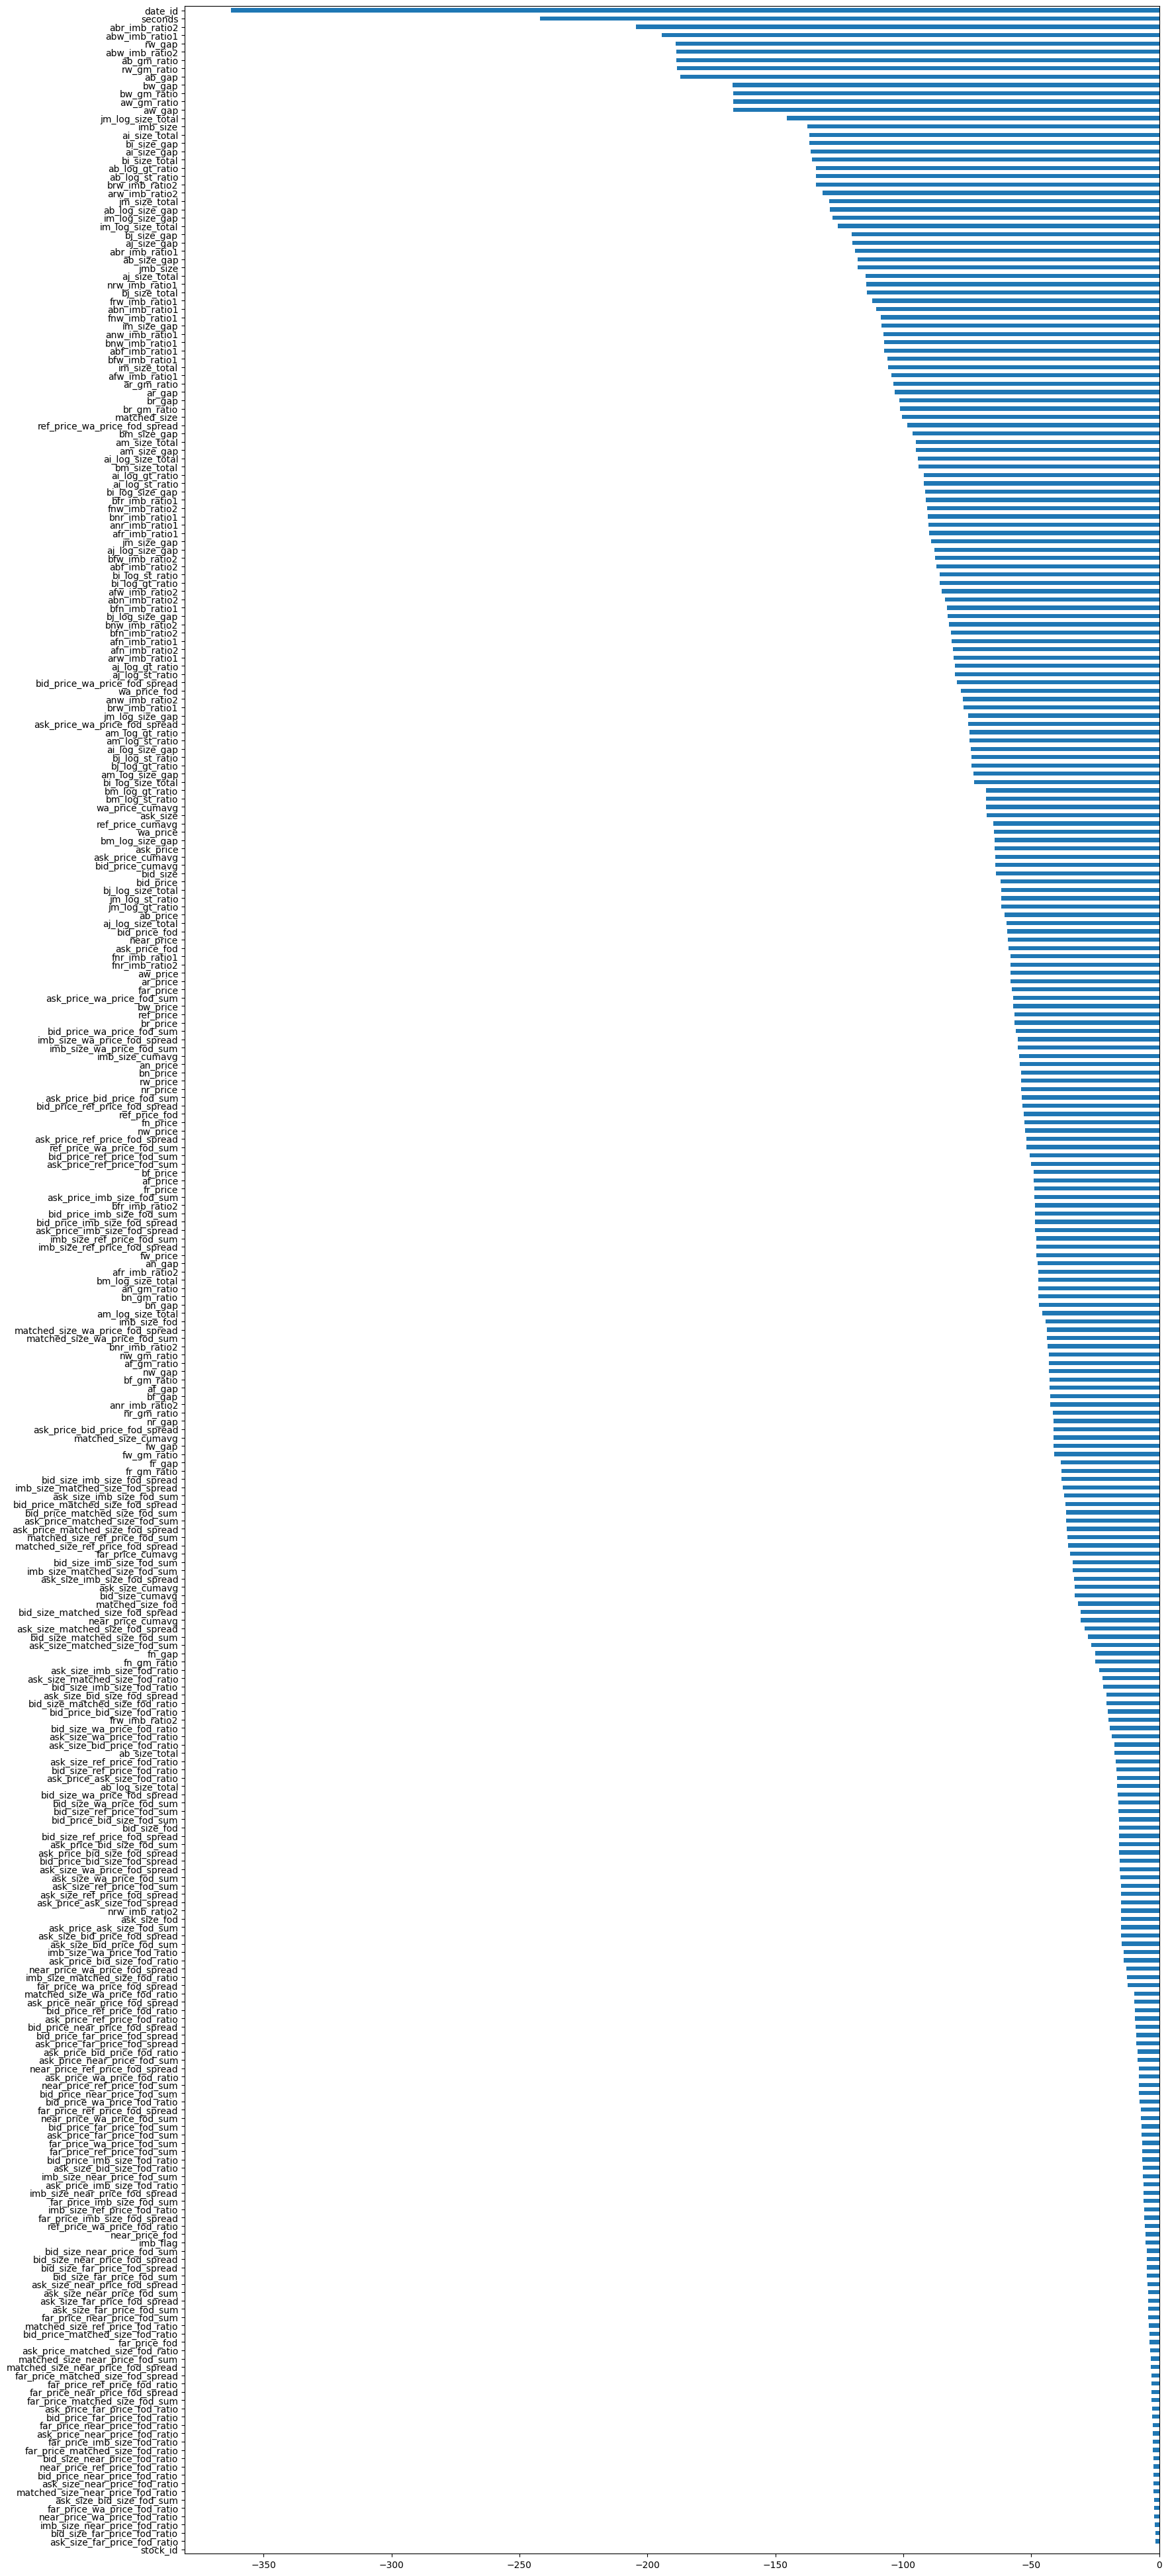

In [40]:
plt.figure(figsize=(19, 50))
all_logp_mean.plot.barh()
plt.show()

In [32]:
train

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,bj_log_st_ratio,bj_log_gt_ratio,aj_size_gap,aj_size_total,aj_st_ratio,aj_gt_ratio,aj_log_size_gap,aj_log_size_total,aj_log_st_ratio,aj_log_gt_ratio
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,...,0.423810,-0.152380,-3.172110e+06,3.189096e+06,0.002663,-0.994674,-5.925462,24.019701,0.376654,-0.246692
1,1,0,0,-1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,0.401967,-0.196067,-1.459988e+05,1.872090e+05,0.110065,-0.779871,-2.090038,21.956722,0.452405,-0.095189
2,2,0,0,-3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,...,0.455172,-0.089655,-2.838849e+05,3.218749e+05,0.059014,-0.881973,-2.769111,22.473079,0.438390,-0.123219
3,3,0,0,-1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,...,0.322384,-0.355231,-1.143865e+07,1.239671e+07,0.038642,-0.922716,-3.214008,29.373060,0.445290,-0.109420
4,4,0,0,-4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,...,0.427355,-0.145290,-4.471159e+05,4.479841e+05,0.000969,-0.998062,-6.935970,19.087122,0.318308,-0.363385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,-2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,...,0.413782,-0.172435,-2.120861e+06,2.760585e+06,0.115868,-0.768265,-2.032156,27.383455,0.462894,-0.074211
5237976,196,480,540,-3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,...,0.489338,-0.021323,-2.561174e+05,4.429035e+05,0.210865,-0.578269,-1.319709,24.208875,0.472743,-0.054513
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,...,1.000000,1.000000,1.800383e+05,1.800383e+05,1.000000,1.000000,12.100930,12.100930,1.000000,1.000000
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,...,0.459400,-0.081201,-3.310058e+05,1.670792e+06,0.400943,-0.198113,-0.401535,27.231285,0.492627,-0.014745


In [24]:
%%time
train_subset = train.loc[:, META_COLUMNS + get_cols(train, contains=["size", "st_ratio", "gt_ratio"])]
a = train_subset.describe()

CPU times: user 8.61 s, sys: 3.73 s, total: 12.3 s
Wall time: 15.7 s


In [25]:
a.loc["min"].sort_values()[:30]

im_size_gap         -6.622212e+09
ai_size_gap         -2.982039e+09
bi_size_gap         -2.982032e+09
imb_size            -2.982028e+09
bi_size_total       -2.982024e+09
bj_size_gap         -2.982024e+09
aj_size_gap         -2.982016e+09
ai_size_total       -2.982016e+09
jm_size_gap         -3.779682e+08
im_size_total       -3.779682e+08
ai_log_gt_ratio     -6.489430e+07
ai_log_st_ratio     -3.244715e+07
bi_log_gt_ratio     -4.586473e+06
ab_size_gap         -2.754827e+06
bi_log_st_ratio     -2.293236e+06
am_size_gap         -2.053116e+06
bm_size_gap         -1.531159e+06
im_log_size_gap     -4.380957e+01
bi_log_size_gap     -3.499870e+01
ai_log_size_gap     -3.494996e+01
bi_log_size_total   -1.569142e+01
bj_log_size_gap     -1.569142e+01
aj_log_size_gap     -1.506936e+01
ai_log_size_total   -1.481485e+01
ab_log_size_gap     -1.033083e+01
jm_log_size_gap     -4.819569e+00
im_log_size_total   -4.819569e+00
am_log_size_gap     -4.593475e+00
bm_log_size_gap     -4.341391e+00
aj_log_gt_rati

ai_gt_ratio                  -inf
im_log_st_ratio              -inf
ai_st_ratio                  -inf
im_gt_ratio                  -inf
im_st_ratio                  -inf
im_log_gt_ratio              -inf
im_size_gap         -6.622212e+09
ai_size_gap         -2.982039e+09
bi_size_gap         -2.982032e+09
imb_size            -2.982028e+09
bj_size_gap         -2.982024e+09
bi_size_total       -2.982024e+09
aj_size_gap         -2.982016e+09
ai_size_total       -2.982016e+09
im_size_total       -3.779682e+08
jm_size_gap         -3.779682e+08
ai_log_gt_ratio     -6.489430e+07
ai_log_st_ratio     -3.244715e+07
bi_log_gt_ratio     -4.586473e+06
ab_size_gap         -2.754827e+06
bi_log_st_ratio     -2.293236e+06
am_size_gap         -2.053116e+06
bm_size_gap         -1.531159e+06
bi_gt_ratio         -5.661761e+05
bi_st_ratio         -2.830875e+05
im_log_size_gap     -4.380957e+01
bi_log_size_gap     -3.499870e+01
ai_log_size_gap     -3.494996e+01
bi_log_size_total   -1.569142e+01
bj_log_size_ga

In [ ]:
plot_heatmap(b, figsize=(19, 12), annot=True, fmt=".2f") # .iloc[:, :-1]

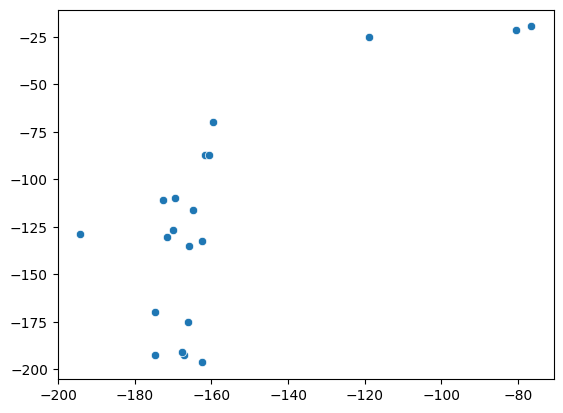

In [420]:
sns.scatterplot(
    x=temp_log_chi_square_p_mean2[temp_log_chi_square_p_mean2.index.str.endswith("imb_ratio")].sort_index().values,
    y=temp_log_chi_square_p_mean2[temp_log_chi_square_p_mean2.index.str.endswith("imb_ratio2")].sort_index().values
)
plt.show()

In [361]:
# %%time
# log_chi_square_p_df, log_chi_square_p_mean = run_chi_square_tests(train)

In [362]:
# log_chi_square_p_df.to_parquet("../feature_log_pvalues.parquet")

In [376]:
log_chi_square_p_mean

near_wa_fod_ratio        -1.848050
far_wa_fod_ratio         -1.976621
ask_bid_fod_sum          -2.080732
bid_near_fod_ratio       -2.208533
near_ref_fod_ratio       -2.255041
                           ...    
bid_ask_sp_ratio       -188.752849
ref_wa_sc_ratio        -189.020183
ref_wa_spread          -189.034052
bid_ask_wa_imb_ratio   -194.339191
seconds                -241.856021
Length: 330, dtype: float64

In [16]:
# plt.figure(figsize=(18, 50))
# log_chi_square_p_mean.plot.barh()
# plt.show(

In [306]:
base_price_cols = get_cols(train, contains="price", excludes=["median", "std", "rbtsc", "stdsc", "r0", "r1", "r2"])
base_volume_cols = get_cols(train, contains="size", excludes=["median", "std", "rbtsc", "stdsc", "r0", "r1", "r2"])

In [307]:
target_columns = ["target", "clipped_target", "binary_target"]
columns_to_shift = base_price_cols + base_volume_cols + get_cols(train, contains="flag")
columns_to_shift

['ref_price',
 'far_price',
 'near_price',
 'bid_price',
 'ask_price',
 'wa_price',
 'imb_size',
 'matched_size',
 'bid_size',
 'ask_size',
 'imb_flag']

In [312]:
%%time
train = get_fod_sod(train, verbose=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.10it/s]
15it [00:00, 76.65it/s]
6it [00:00, 75.22it/s]

CPU times: user 2.17 s, sys: 6.15 s, total: 8.32 s
Wall time: 11.5 s


In [313]:
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 6.9 GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 193.70it/s]

After downcast: 	RAM used: 7.1 GB


In [314]:
train.shape

(5237760, 336)

In [5]:
%%time
# train.to_parquet("../train_all.parquet")
train = pd.read_parquet("../train_all.parquet")

CPU times: user 14 s, sys: 17 s, total: 31 s
Wall time: 12.2 s


In [37]:
# train = pd.read_parquet("../train_all.parquet")

In [38]:
# train_only = pd.read_parquet("../train_only.parquet")

# Stock Date Reference Features

In [11]:
del master_df
gc.collect()

22

## Feature Preparation

In [67]:
%%time
daily_target_df = get_master_daily_target_data(train, verbose=1)

3it [00:20,  6.85s/it]

CPU times: user 19.8 s, sys: 1.33 s, total: 21.2 s
Wall time: 21.5 s


In [68]:
daily_target_df

target_r0_grad  daily_target_r0_mean  daily_target_r0_std  \
stock_id date_id                                                              
0        0              0.013968             -0.734535             4.185723   
         1              0.100066              0.328942             4.007034   
         2              0.051576             -0.326709             5.143942   
         3              0.012219             -3.225099             5.174628   
         4             -0.190581             -1.614007             9.171227   
...                          ...                   ...                  ...   
199      476           -0.182926              0.966506             5.772027   
         477            0.130969             -4.226024             4.536808   
         478            0.044484              1.323125             5.631495   
         479           -0.170431              3.300006             4.847999   
         480           -0.062796              2.684723             4.638748   

                  daily_target_r0_min  daily_target_r0_max  \
stock_id date_id                                             
0        0                 -10.679960             9.759665   
         1                 -14.089942             6.799698   
         2                 -15.569925             8.629560   
         3                 -17.899872             8.759499   
         4                 -19.440056            18.730164   
...                               ...                  ...   
199      476               -10.579824            12.860298   
         477               -15.050173             3.709793   
         478               -11.900067            13.500452   
         479                -8.689761            11.539459   
         480                -9.750128            12.979507   

                  target_fod_r0_mean  target_sod_r0_mean  target_r1_grad  \
stock_id date_id                                                           
0        0                  0.236840            0.003767       -0.143111   
         1                  0.210923           -0.311901        0.015331   
         2                  0.155171           -0.093028       -0.038804   
         3                 -0.004073           -0.044332       -0.131106   
         4                 -0.339813           -0.298676       -1.082736   
...                              ...                 ...             ...   
199      476               -0.179818            0.007929        0.291417   
         477                0.153140            0.125856        0.013376   
         478                0.431858           -0.041318        0.390283   
         479               -0.214257            0.033401        0.095531   
         480               -0.296478           -0.077554        0.124265   

                  daily_target_r1_mean  daily_target_r1_std  ...  \
stock_id date_id                                             ...   
0        0                   -0.543912             4.044231  ...   
         1                   -0.937978             4.188137  ...   
         2                   -1.440028             6.140994  ...   
         3                   -3.650665             5.493899  ...   
         4                   -1.950661            11.711822  ...   
...                                ...                  ...  ...   
199      476                  4.173656             4.683441  ...   
         477                 -6.164352             4.365736  ...   
         478                  1.912057             6.364238  ...   
         479                  5.752981             3.970762  ...   
         480                  3.896912             4.508878  ...   

                  daily_target_r1_max  target_fod_r1_mean  target_sod_r1_mean  \
stock_id date_id                                                                
0        0                   6.630421           -0.263802           -0.154972   
         1                   6.450415            0.255868         

In [48]:
daily_target_df

,stock_id,date_id,target_r0_grad,daily_target_r0_mean,daily_target_r0_std,daily_target_r0_min,daily_target_r0_max,target_fod_r0_mean,target_sod_r0_mean,target_r1_grad,...,daily_target_r1_max,target_fod_r1_mean,target_sod_r1_mean,target_r2_grad,daily_target_r2_mean,daily_target_r2_std,daily_target_r2_min,daily_target_r2_max,target_fod_r2_mean,target_sod_r2_mean
0,0,0,0.013968,-0.734535,4.185723,-10.679960,9.759665,0.236840,0.003767,-0.143111,...,6.630421,-0.263802,-0.154972,0.517306,-0.963283,4.422378,-10.039806,9.759665,0.824978,-0.016560
1,0,1,0.100066,0.328942,4.007034,-14.089942,6.799698,0.210923,-0.311901,0.015331,...,6.450415,0.255868,-0.467492,0.236347,1.849246,3.243143,-5.589724,6.799698,0.120401,-0.486944
2,0,2,0.051576,-0.326709,5.143942,-15.569925,8.629560,0.155171,-0.093028,-0.038804,...,6.990433,0.365849,-0.074995,-0.089561,1.009274,3.249354,-5.400181,8.629560,-0.064174,0.011662
3,0,3,0.012219,-3.225099,5.174628,-17.899872,8.759499,-0.004073,-0.044332,-0.131106,...,8.759499,0.575493,0.111056,0.086869,-2.714419,4.824796,-8.730292,7.859468,-0.178317,-0.279572
4,0,4,-0.190581,-1.614007,9.171227,-19.440056,18.730164,-0.339813,-0.298676,-1.082736,...,18.730164,-0.339644,-0.006067,-0.373649,-1.210022,4.816206,-12.429953,7.090569,-0.496258,0.091765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95227,199,476,-0.182926,0.966506,5.772027,-10.579824,12.860298,-0.179818,0.007929,0.291417,...,12.860298,0.146545,-0.236077,-0.418779,-2.882075,4.491251,-10.579824,5.019903,-0.508750,0.205636
95228,199,477,0.130969,-4.226024,4.536808,-15.050173,3.709793,0.153140,0.125856,0.013376,...,3.340244,0.357587,0.065374,0.143114,-1.900029,3.598391,-7.039905,3.709793,0.270406,0.431304
95229,199,478,0.044484,1.323125,5.631495,-11.900067,13.500452,0.431858,-0.041318,0.390283,...,13.500452,0.476570,-0.438179,0.173276,0.616407,4.632529,-5.130172,11.420250,0.459601,-0.032187
95230,199,479,-0.170431,3.300006,4.847999,-8.689761,11.539459,-0.214257,0.033401,0.095531,...,11.539459,0.224812,0.240718,-0.425522,0.356436,4.157311,-8.689761,6.419420,-0.265415,-0.265629


In [58]:
daily_target_df

,stock_id,date_id,target_r0_grad,daily_target_r0_mean,daily_target_r0_std,daily_target_r0_min,daily_target_r0_max,target_fod_r0_mean,target_sod_r0_mean,target_r1_grad,...,daily_target_r1_max,target_fod_r1_mean,target_sod_r1_mean,target_r2_grad,daily_target_r2_mean,daily_target_r2_std,daily_target_r2_min,daily_target_r2_max,target_fod_r2_mean,target_sod_r2_mean
0,0.0,0.0,0.013968,-0.734535,4.185723,-10.679960,9.759665,0.236840,0.003767,-0.143111,...,6.630421,-0.263802,-0.154972,0.517306,-0.963283,4.422378,-10.039806,9.759665,0.824978,-0.016560
1,0.0,1.0,0.100066,0.328942,4.007034,-14.089942,6.799698,0.210923,-0.311901,0.015331,...,6.450415,0.255868,-0.467492,0.236347,1.849246,3.243143,-5.589724,6.799698,0.120401,-0.486944
2,0.0,2.0,0.051576,-0.326709,5.143942,-15.569925,8.629560,0.155171,-0.093028,-0.038804,...,6.990433,0.365849,-0.074995,-0.089561,1.009274,3.249354,-5.400181,8.629560,-0.064174,0.011662
3,0.0,3.0,0.012219,-3.225099,5.174628,-17.899872,8.759499,-0.004073,-0.044332,-0.131106,...,8.759499,0.575493,0.111056,0.086869,-2.714419,4.824796,-8.730292,7.859468,-0.178317,-0.279572
4,0.0,4.0,-0.190581,-1.614007,9.171227,-19.440056,18.730164,-0.339813,-0.298676,-1.082736,...,18.730164,-0.339644,-0.006067,-0.373649,-1.210022,4.816206,-12.429953,7.090569,-0.496258,0.091765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95228,199.0,477.0,0.130969,-4.226024,4.536808,-15.050173,3.709793,0.153140,0.125856,0.013376,...,3.340244,0.357587,0.065374,0.143114,-1.900029,3.598391,-7.039905,3.709793,0.270406,0.431304
95229,199.0,478.0,0.044484,1.323125,5.631495,-11.900067,13.500452,0.431858,-0.041318,0.390283,...,13.500452,0.476570,-0.438179,0.173276,0.616407,4.632529,-5.130172,11.420250,0.459601,-0.032187
95230,199.0,479.0,-0.170431,3.300006,4.847999,-8.689761,11.539459,-0.214257,0.033401,0.095531,...,11.539459,0.224812,0.240718,-0.425522,0.356436,4.157311,-8.689761,6.419420,-0.265415,-0.265629
95231,199.0,480.0,-0.062796,2.684723,4.638748,-9.750128,12.979507,-0.296478,-0.077554,0.124265,...,12.979507,-0.303778,0.203209,-0.115068,1.230097,4.450754,-9.750128,9.020567,-0.239188,-0.579590


In [39]:
train.merge(daily_target_df, on=["stock_id", "date_id"])

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,daily_target_r1_max,target_fod_r1_mean,target_sod_r1_mean,target_r2_grad,daily_target_r2_mean,daily_target_r2_std,daily_target_r2_min,daily_target_r2_max,target_fod_r2_mean,target_sod_r2_mean
0,0,0,0,3180602.750,1,0.999812,13380277.0,NaN,NaN,0.999812,...,6.630421,-0.263802,-0.154972,0.517306,-0.963283,4.422378,-10.039806,9.759665,0.824978,-0.01656
1,0,0,10,1299772.750,1,1.000026,15261107.0,NaN,NaN,0.999812,...,6.630421,-0.263802,-0.154972,0.517306,-0.963283,4.422378,-10.039806,9.759665,0.824978,-0.01656
2,0,0,20,1299772.750,1,0.999919,15261107.0,NaN,NaN,0.999812,...,6.630421,-0.263802,-0.154972,0.517306,-0.963283,4.422378,-10.039806,9.759665,0.824978,-0.01656
3,0,0,30,1299772.750,1,1.000133,15261107.0,NaN,NaN,1.000026,...,6.630421,-0.263802,-0.154972,0.517306,-0.963283,4.422378,-10.039806,9.759665,0.824978,-0.01656
4,0,0,40,1218204.375,1,1.000455,15342675.0,NaN,NaN,1.000241,...,6.630421,-0.263802,-0.154972,0.517306,-0.963283,4.422378,-10.039806,9.759665,0.824978,-0.01656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237755,199,480,500,-2661783.500,-1,1.002764,23969216.0,1.000859,1.001494,1.002764,...,12.979507,-0.303778,0.203209,-0.115068,1.230097,4.450754,-9.750128,9.020567,-0.239188,-0.57959
5237756,199,480,510,-2658917.500,-1,1.002764,23972082.0,1.000859,1.001494,1.002764,...,12.979507,-0.303778,0.203209,-0.115068,1.230097,4.450754,-9.750128,9.020567,-0.239188,-0.57959
5237757,199,480,520,-1352558.875,-1,1.001812,23978380.0,1.000859,1.001494,1.001812,...,12.979507,-0.303778,0.203209,-0.115068,1.230097,4.450754,-9.750128,9.020567,-0.239188,-0.57959
5237758,199,480,530,-1352558.875,-1,1.001812,23978380.0,1.000859,1.001494,1.001812,...,12.979507,-0.303778,0.203209,-0.115068,1.230097,4.450754,-9.750128,9.020567,-0.239188,-0.57959


In [14]:
# daily_price_df = pd.read_parquet("../daily_price.parquet")
# daily_target_df = pd.read_parquet("../daily_target.parquet")
# daily_volume_df = pd.read_parquet("../daily_volume.parquet")

In [15]:
%%time

interday_target_features = generate_interday_target_features(daily_target_df, verbose=1)

3it [00:20,  6.72s/it]


Generating Interday gradient features for each column...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:22<00:00,  6.87s/it]

CPU times: user 1min 41s, sys: 1.41 s, total: 1min 43s
Wall time: 1min 43s


In [16]:
%%time
daily_price_df = get_master_daily_price_data(train, verbose=1)
interday_price_features = generate_interday_price_features(daily_price_df, verbose=1)

3it [00:22,  7.54s/it]


Generating Interday gradient features for each column...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [05:24<00:00,  6.75s/it]


CPU times: user 5min 46s, sys: 2.3 s, total: 5min 48s
Wall time: 5min 47s


In [17]:
%%time
daily_volume_df = get_master_daily_volume_data(train, verbose=1)
interday_volume_features = generate_interday_volume_features(daily_volume_df, verbose=1)

3it [00:21,  7.27s/it]


Generating Interday gradient features for each column...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [05:04<00:00,  6.77s/it]


CPU times: user 5min 25s, sys: 2.2 s, total: 5min 27s
Wall time: 5min 27s


In [18]:
# interday_target_features.to_parquet("../intraday_target.parquet")
# interday_price_features.to_parquet("../intraday_price.parquet")
# interday_volume_features.to_parquet("../intraday_volume.parquet")

In [19]:
# daily_target_df.to_parquet("../daily_target.parquet")
# daily_price_df.to_parquet("../daily_price.parquet")
# daily_volume_df.to_parquet("../daily_volume.parquet")

## Merge Additional Ready Data

In [20]:
def merge_additional_info(
    df, 
    merge_by_stock=[weight_df], 
    merge_by_stock_date=[interday_target_features, interday_price_features, interday_volume_features]
):
    # Merge static stock information
    for stock_df in merge_by_stock:
        df = df.merge(stock_df, on="stock_id", how="left")
    
    # Merge interday features
    for stock_date_df in merge_by_stock_date:
        df = df.merge(stock_date_df, left_on=["stock_id", "date_id"], right_index=True, how="left")
    return df

In [21]:
%%time
train = merge_additional_info(train)

CPU times: user 6.8 s, sys: 35.4 s, total: 42.2 s
Wall time: 1min 9s


In [22]:
check_memory_usage(color="blue")

RAM used: 0.5 GB


0.5390472412109375

In [23]:
train.tail()

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,trade_size_r2_min_3days_gradient,trade_size_r2_min_6days_gradient,trade_size_r2_max_3days_gradient,trade_size_r2_max_6days_gradient,imb_size_ld1_r2_mean_3days_gradient,imb_size_ld1_r2_mean_6days_gradient,matched_size_ld1_r2_mean_3days_gradient,matched_size_ld1_r2_mean_6days_gradient,trade_size_ld1_r2_mean_3days_gradient,trade_size_ld1_r2_mean_6days_gradient
5237975,199,480,500,-2661783.500,-1,1.002764,23969216.0,1.000859,1.001494,1.002764,...,21415.957031,-2959.94721,37177.46875,-14914.027679,-283196.686198,-27686.949256,30024.020833,35456.567857,656.729574,-227.020954
5237976,199,480,510,-2658917.500,-1,1.002764,23972082.0,1.000859,1.001494,1.002764,...,21415.957031,-2959.94721,37177.46875,-14914.027679,-283196.686198,-27686.949256,30024.020833,35456.567857,656.729574,-227.020954
5237977,199,480,520,-1352558.875,-1,1.001812,23978380.0,1.000859,1.001494,1.001812,...,21415.957031,-2959.94721,37177.46875,-14914.027679,-283196.686198,-27686.949256,30024.020833,35456.567857,656.729574,-227.020954
5237978,199,480,530,-1352558.875,-1,1.001812,23978380.0,1.000859,1.001494,1.001812,...,21415.957031,-2959.94721,37177.46875,-14914.027679,-283196.686198,-27686.949256,30024.020833,35456.567857,656.729574,-227.020954
5237979,199,480,540,-1884285.750,-1,1.002129,24073678.0,1.000859,1.001494,1.002129,...,21415.957031,-2959.94721,37177.46875,-14914.027679,-283196.686198,-27686.949256,30024.020833,35456.567857,656.729574,-227.020954


## Test Submission Mode

In [43]:
%%time
val_iter_zip = joblib.load(f'{DATA_DIR}/optiver-train-data/iter_val_subset.pkl')
# val_iter_zip = joblib.load(f'{DATA_DIR}/optiver-test-data/iter_test_copy.pkl')

CPU times: user 153 ms, sys: 11.1 ms, total: 164 ms
Wall time: 164 ms


In [44]:
def process_revealed_targets(revealed_targets):
    revealed_targets = revealed_targets.drop(columns=["revealed_date_id", "revealed_time_id"], errors="ignore")
    revealed_targets["date_id"] -= 1
    revealed_targets = revealed_targets.rename(columns={"revealed_target": "target"})
    revealed_targets = clean_df(revealed_targets)
    daily_target_df = get_master_daily_target_data(revealed_targets)
    return daily_target_df

In [45]:
price_clippers = joblib.load(f"{DATA_DIR}/optiver-preprocess-helpers/price_clippers.pkl")
volume_clippers = joblib.load(f"{DATA_DIR}/optiver-preprocess-helpers/volume_clippers.pkl")

In [46]:
intraday_list = []
test_list = []
targets_list = []
sample_pred_list = []
count = 0
max_lookback_period = 14

In [49]:
recent_interday_price_features = filter_df(interday_price_features.reset_index(), date_id=TRAIN_END_DATE).set_index(["stock_id", "date_id"])
recent_interday_volume_features = filter_df(interday_volume_features.reset_index(), date_id=TRAIN_END_DATE).set_index(["stock_id", "date_id"])
recent_interday_target_features = filter_df(interday_target_features.reset_index(), date_id=TRAIN_END_DATE).set_index(["stock_id", "date_id"])

In [51]:
%%time
for i, (test, revealed_targets, sample_prediction) in tqdm(enumerate(val_iter_zip)):
    date_id = test["date_id"][0]
    test["order"] = range(test.shape[0])
    
    # Reset list if next day (seconds == 0) is seen
    second = test["seconds_in_bucket"].values[0]
    
    # If second == 0, means we get the full previous day info for building features
    if second == 0 and i > 0:
        # At this moment, the intraday df has the full 0 - 540 seconds data for the previous day
        
        # Get previous day price and volume df
        prev_day_price_df = get_master_daily_price_data(intraday_df)
        prev_day_volume_df = get_master_daily_volume_data(intraday_df)
        
        # Merge previous day prices (volumes) into master daily price (volume)
        daily_price_df = pd.concat([daily_price_df, prev_day_price_df]).sort_values(by=["stock_id", "date_id"]).reset_index()
        daily_price_df = daily_price_df.loc[daily_price_df["date_id"] > date_id - max_lookback_period].set_index(["stock_id", "date_id"])
        
        daily_volume_df = pd.concat([daily_volume_df, prev_day_volume_df]).sort_values(by=["stock_id", "date_id"]).reset_index()
        daily_volume_df = daily_volume_df.loc[daily_volume_df["date_id"] > date_id - max_lookback_period].set_index(["stock_id", "date_id"])
        
        # Generate interday price & volume features
        recent_interday_price_features = generate_interday_price_features(daily_price_df).reset_index()
        recent_interday_price_features = filter_df(recent_interday_price_features, date_id=date_id).set_index(["stock_id", "date_id"])
        
        recent_interday_volume_features = generate_interday_volume_features(daily_volume_df).reset_index()
        recent_interday_volume_features = filter_df(recent_interday_volume_features, date_id=date_id).set_index(["stock_id", "date_id"])
        
        # Reset intraday list
        intraday_list = []
        
        # Process previous revealed target
        prev_day_target_df = process_revealed_targets(revealed_targets)
        
        # Merge previous day targets into master daily target
        daily_target_df = pd.concat([daily_target_df, prev_day_target_df]).sort_values(by=["stock_id", "date_id"]).reset_index()
        daily_target_df = daily_target_df.loc[daily_target_df["date_id"] > date_id - max_lookback_period].set_index(["stock_id", "date_id"])
        
        # Generate interday target features
        recent_interday_target_features = generate_interday_target_features(daily_target_df).reset_index()
        recent_interday_target_features = filter_df(recent_interday_target_features, date_id=date_id).set_index(["stock_id", "date_id"])
        
        
    intraday_list.append(test)
    
    intraday_df = pd.concat(intraday_list, ignore_index=True)
    intraday_df = clean_df(intraday_df, verbose=0)
    intraday_df = clip_df(intraday_df, price_clippers=price_clippers, volume_clippers=volume_clippers)
    
    final_df = merge_additional_info(
        intraday_df, 
        merge_by_stock_date=[recent_interday_target_features, recent_interday_price_features, recent_interday_volume_features]
    )
    final_df, _ = feature_engineering(final_df, around_one_price_cols=around_one_price_cols)
    final_df = get_fod_sod(final_df)
    final_df = filter_df(final_df, seconds=second).sort_values(by="order").drop(columns="order").reset_index(drop=True)
    test_list.append(final_df)
    
    del final_df
    gc.collect()

275it [02:07,  2.16it/s]

CPU times: user 2min 2s, sys: 4.32 s, total: 2min 7s
Wall time: 2min 7s


In [52]:
%%time
full_test = my_concat(test_list)

CPU times: user 284 ms, sys: 48 ms, total: 332 ms
Wall time: 335 ms


In [55]:
# full_test.to_parquet("../test_only.parquet")

In [97]:
validate = filter_df(train, date_id=(full_test["date_id"].min(), full_test["date_id"].max()))

In [98]:
validate = validate.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)
full_test = full_test.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)

In [104]:
full_test

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563360e+05,-5.648820e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [105]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563361e+05,-5.648819e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [111]:
(1 - ((validate[col] + 1e-6) / (full_test[col] + 1e-6))).max()

inf

In [124]:
col

'imb_matched_fod_ratio'

In [128]:
full_test.shape

(52800, 750)

In [127]:
full_test.loc[(f - v) > 0.1]

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
3026,11,30,10,1.028579e+05,1,0.999756,2.662660e+06,NaN,NaN,0.999220,...,-0.840583,2.705311e+05,-3.679639e+05,-0.735211,-3.679639e+05,2.705311e+05,-1.360154,-6.384950e+05,-0.007812,8.172736e+07
3161,11,32,260,2.167491e+05,1,1.000032,1.684401e+07,NaN,NaN,0.999950,...,-1.069216,8.799182e+05,-8.706539e+05,-1.010641,-8.706539e+05,8.799181e+05,-0.989471,-1.750572e+06,-0.031250,5.601830e+07
3286,11,34,410,2.166614e+05,1,1.001938,2.065324e+07,1.003420,1.002658,1.001431,...,-0.958433,3.887681e+05,-2.609799e+05,-1.489648,-2.609799e+05,3.887681e+05,-0.671300,-6.497480e+05,-0.015625,4.158387e+07
11059,40,31,40,5.382560e+03,1,1.000268,1.225791e+07,NaN,NaN,0.999897,...,-0.193090,3.682110e+04,-3.961118e+04,-0.929563,-3.961104e+04,3.682096e+04,-1.075774,-7.643214e+04,-0.139160,5.492387e+05
12943,47,30,180,3.183710e+03,1,1.001066,2.870611e+06,NaN,NaN,1.000516,...,-1.141596,2.698811e+05,-2.811729e+05,-0.959841,-2.811729e+05,2.698811e+05,-1.041840,-5.510540e+05,-0.008789,6.269770e+07
13531,49,31,10,2.219520e+03,1,0.999877,2.978967e+07,NaN,NaN,0.999629,...,-0.863124,5.405369e+05,-5.311296e+05,-1.017712,-5.311283e+05,5.405357e+05,-0.982596,-1.071665e+06,-1.229980,8.712864e+05
16711,60,33,460,3.558425e+04,1,1.005087,3.619211e+08,1.005126,1.005087,1.004820,...,-0.997202,7.344856e+06,-7.298586e+06,-1.006340,-7.298561e+06,7.344831e+06,-0.993700,-1.464342e+07,-24.750000,5.916532e+05
21311,78,32,260,1.441122e+04,1,1.002314,4.595754e+06,NaN,NaN,1.001359,...,-1.038866,7.659310e+04,-5.955940e+04,-1.285995,-5.955965e+04,7.659335e+04,-0.777609,-1.361527e+05,0.250977,-5.424919e+05
23372,86,34,520,1.110532e+06,1,0.998044,1.602998e+08,0.998861,0.998282,0.997806,...,-0.807021,-1.054450e+06,1.113102e+06,-0.947308,1.112814e+06,-1.054162e+06,-1.055639,2.167264e+06,288.095703,7.522723e+03
24523,91,30,480,7.484260e+04,1,1.002525,1.644532e+07,1.002675,1.002638,1.002413,...,-0.737358,9.010615e+05,-8.930226e+05,-1.009002,-8.930226e+05,9.010614e+05,-0.991078,-1.794084e+06,-0.023438,7.654758e+07


In [123]:
validate.loc[(f - v) > 0.1]

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
3026,11,30,10,1.028579e+05,1,0.999756,2.662660e+06,NaN,NaN,0.999220,...,-0.840583,2.705311e+05,-3.679639e+05,-0.735211,-3.679639e+05,2.705311e+05,-1.360154,-6.384950e+05,0.000000,-inf
3161,11,32,260,2.167491e+05,1,1.000032,1.684401e+07,NaN,NaN,0.999950,...,-1.069216,8.799181e+05,-8.706539e+05,-1.010641,-8.706539e+05,8.799181e+05,-0.989471,-1.750572e+06,0.000000,-inf
3286,11,34,410,2.166614e+05,1,1.001938,2.065324e+07,1.003420,1.002658,1.001431,...,-0.958433,3.887681e+05,-2.609799e+05,-1.489648,-2.609799e+05,3.887681e+05,-0.671300,-6.497480e+05,0.000000,-inf
11059,40,31,40,5.382560e+03,1,1.000268,1.225791e+07,NaN,NaN,0.999897,...,-0.193090,3.682110e+04,-3.961118e+04,-0.929563,-3.961104e+04,3.682096e+04,-1.075774,-7.643214e+04,-0.140625,5.435174e+05
12943,47,30,180,3.183710e+03,1,1.001066,2.870611e+06,NaN,NaN,1.000516,...,-1.141596,2.698811e+05,-2.811729e+05,-0.959841,-2.811729e+05,2.698811e+05,-1.041840,-5.510540e+05,0.000000,-inf
13531,49,31,10,2.219520e+03,1,0.999877,2.978967e+07,NaN,NaN,0.999629,...,-0.863124,5.405369e+05,-5.311296e+05,-1.017712,-5.311283e+05,5.405357e+05,-0.982596,-1.071665e+06,-1.250000,8.573322e+05
16711,60,33,460,3.558425e+04,1,1.005087,3.619211e+08,1.005126,1.005087,1.004820,...,-0.997202,7.344856e+06,-7.298586e+06,-1.006340,-7.298561e+06,7.344831e+06,-0.993700,-1.464342e+07,-25.000000,5.857367e+05
21311,78,32,260,1.441122e+04,1,1.002314,4.595754e+06,NaN,NaN,1.001359,...,-1.038866,7.659310e+04,-5.955940e+04,-1.285995,-5.955965e+04,7.659335e+04,-0.777609,-1.361528e+05,0.250000,-5.446110e+05
23372,86,34,520,1.110532e+06,1,0.998044,1.602998e+08,0.998861,0.998282,0.997806,...,-0.807021,-1.054450e+06,1.113102e+06,-0.947308,1.112814e+06,-1.054162e+06,-1.055639,2.167264e+06,288.125000,7.521958e+03
24523,91,30,480,7.484260e+04,1,1.002525,1.644532e+07,1.002675,1.002638,1.002413,...,-0.737358,9.010614e+05,-8.930226e+05,-1.009002,-8.930226e+05,9.010614e+05,-0.991078,-1.794084e+06,0.000000,-inf


In [117]:
v.describe()

count      35384.000000
mean      -16188.621094
std       216558.734375
min     -1000000.000000
25%           -1.000000
50%            0.000001
75%            1.000000
max      1000000.000000
Name: imb_matched_fod_ratio, dtype: float64

In [139]:
4.361572e-07 / 4.523112e-07

0.9642856511180797

In [154]:
full_test.shape[0], validate.shape[0]

(52800, 52800)

In [157]:
full_test.loc[(1 - v / f).abs() < 1e-3, col]

2        0.000774
3       -0.000470
4        0.000748
5        0.000132
6        0.000029
           ...   
52793    0.000193
52795   -0.000134
52796   -0.000179
52798   -0.000227
52799   -0.000090
Name: wa_price_l1_l2_ratio_diff, Length: 45251, dtype: float32

In [158]:
validate.loc[(1 - v / f).abs() < 1e-3, col]

2        0.000774
3       -0.000470
4        0.000748
5        0.000132
6        0.000029
           ...   
52793    0.000193
52795   -0.000134
52796   -0.000179
52798   -0.000227
52799   -0.000090
Name: wa_price_l1_l2_ratio_diff, Length: 45251, dtype: float32

In [159]:
full_test.loc[(1 - v / f).abs() > 1e-3, col]

10      -0.000032
40      -0.000053
66       0.000006
94      -0.000046
95      -0.000047
           ...   
52749    0.000084
52755    0.000038
52780   -0.000002
52794    0.000002
52797   -0.000007
Name: wa_price_l1_l2_ratio_diff, Length: 4860, dtype: float32

In [160]:
validate.loc[(1 - v / f).abs() > 1e-3, col]

10      -0.000032
40      -0.000053
66       0.000006
94      -0.000046
95      -0.000047
           ...   
52749    0.000084
52755    0.000038
52780   -0.000002
52794    0.000002
52797   -0.000007
Name: wa_price_l1_l2_ratio_diff, Length: 4860, dtype: float32

In [152]:
col = "wa_price_l1_l2_ratio_diff"

In [153]:
v = validate[col].clip(-1e6, 1e6)
f = full_test[col].clip(-1e6, 1e6)
deviate_many_count = ((1 - v / f).abs() > 1e-3).sum()

In [144]:
count = 0
for col in full_test.columns:
    v = validate[col].clip(-1e6, 1e6)
    f = full_test[col].clip(-1e6, 1e6)
    deviate_many_count = ((1 - v / f).abs() > 1e-3).sum()
    if deviate_many_count > 0:
        count += 1
        pct = deviate_many_count / full_test.shape[0]
        cprint(f"{col}: {pct:.3%}", color="blue")

ref_price_r0_mean_3days_gradient: 1.146%
ref_price_r0_mean_6days_gradient: 0.417%
bid_price_r0_mean_3days_gradient: 1.354%
bid_price_r0_mean_6days_gradient: 0.729%
wa_price_r0_mean_3days_gradient: 0.521%
wa_price_r0_mean_6days_gradient: 0.938%
ref_price_r1_mean_3days_gradient: 1.562%
ref_price_r1_mean_6days_gradient: 1.042%
bid_price_r1_mean_3days_gradient: 1.042%
bid_price_r1_mean_6days_gradient: 0.625%
wa_price_r1_mean_3days_gradient: 1.458%
wa_price_r1_mean_6days_gradient: 1.354%
bid_price_ld1_r1_mean_3days_gradient: 0.104%
ref_price_r2_mean_3days_gradient: 0.312%
ref_price_r2_mean_6days_gradient: 0.625%
bid_price_r2_mean_3days_gradient: 0.938%
bid_price_r2_mean_6days_gradient: 0.938%
bid_price_r2_std_3days_gradient: 0.104%
wa_price_r2_mean_3days_gradient: 0.521%
wa_price_r2_mean_6days_gradient: 0.833%
bid_price_ld1_r2_mean_3days_gradient: 0.208%
ask_price_ld1_r2_mean_3days_gradient: 0.312%
ref_price_l1_l2_ratio_diff: 2.231%
ref_price_sc_l1_l2_ratio_diff: 4.277%
far_price_l1_l2_rati

In [99]:
full_test

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563360e+05,-5.648820e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [100]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563361e+05,-5.648819e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [39]:
# test_only = pd.read_parquet("../test_only.parquet")

In [43]:
validate = validate.reset_index(drop=True)

In [48]:
list_diff(validate.columns, test_only.columns)

['is_positive_target', 'clipped_target', 'is_mild_target', 'target']

In [69]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,421,0,1.150879e+07,1,0.999406,11354174.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,421,10,1.146589e+07,1,1.000167,11357118.0,NaN,NaN,0.999787,...,1.613970,77751.679688,-8044.320312,-9.665413,31909.679688,37797.679688,0.844223,-45842.0000,-39954.0000,1.147370
2,0,421,20,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,-54095.660156,-14245.660156,3.797343,-34170.660156,-34170.660156,1.000000,19925.0000,19925.0000,1.000000
3,0,421,30,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,2521.919922,2521.919922,1.000000,2521.919922,2521.919922,1.000000,0.0000,0.0000,NaN
4,0,421,40,1.104316e+07,1,0.999596,11799768.0,NaN,NaN,0.999406,...,-0.895805,422947.500000,-462352.500000,-0.914773,-462352.500000,422947.500000,-1.093168,-885300.0000,0.0000,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,199,430,500,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.002812,...,1.000000,165147.500000,165147.500000,1.000000,165147.500000,165147.500000,1.000000,0.0000,0.0000,NaN
109996,199,430,510,-5.526023e+05,-1,1.002812,27788746.0,1.002812,1.002812,1.002812,...,-0.098872,-765899.500000,730308.375000,-1.048734,-73459.531250,37868.468750,-1.939860,692439.9375,803767.9375,0.861492
109997,199,430,520,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,-0.260985,785802.750000,-710405.125000,-1.106133,93362.812500,-17965.187500,-5.196874,-692439.9375,-803767.9375,0.861492
109998,199,430,530,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,1.000000,50457.468750,50457.468750,1.000000,50457.468750,50457.468750,1.000000,0.0000,0.0000,NaN


In [71]:
col = "target_r0_grad_ld1"

In [76]:
test_only

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ref_near_wa_imb_ratio,far_near_bid_imb_ratio,far_near_ask_imb_ratio,far_near_wa_imb_ratio,far_bid_ask_imb_ratio,far_bid_wa_imb_ratio,far_ask_wa_imb_ratio,near_bid_ask_imb_ratio,near_bid_wa_imb_ratio,near_ask_wa_imb_ratio
0,0,421,0,1.150879e+07,1,0.999406,11354174.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,421,10,1.146589e+07,1,1.000167,11357118.0,NaN,NaN,0.999787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,421,20,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,421,30,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,421,40,1.104316e+07,1,0.999596,11799768.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,199,430,500,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.002812,...,0.999813,0.999999,1.000667,1.000260,1.000667,1.000260,1.000147,1.000667,1.000260,1.000147
109996,199,430,510,-5.526023e+05,-1,1.002812,27788746.0,1.002812,1.002812,1.002812,...,1.000109,0.999999,1.000333,1.000109,1.000333,1.000109,1.000114,1.000333,1.000109,1.000114
109997,199,430,520,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,0.999802,1.000333,1.000667,1.000468,1.000001,0.999802,0.999731,1.000001,0.999802,0.999731
109998,199,430,530,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,0.999780,1.000333,1.000667,1.000446,1.000001,0.999780,0.999776,1.000001,0.999780,0.999776


In [75]:
test_only.loc[(test_only[col] - validate[col]) > 1e-5, "date_id"].unique()

array([427, 429, 430, 425, 426, 428], dtype=int32)

target_r0_grad_ld1: 0.8701
target_r1_grad_ld1: 2.0447
target_r2_grad_ld1: 2.5159
target_r0_grad_ma2: 0.4753
target_r1_grad_ma2: 0.9711
target_r2_grad_ma2: 1.6292
daily_target_r0_mean_3days_gradient: 7.1564
daily_target_r0_mean_6days_gradient: 2.7346
daily_target_r0_std_3days_gradient: 11.5913
daily_target_r0_std_6days_gradient: 7.4214
daily_target_r0_min_3days_gradient: 21.3099
daily_target_r0_min_6days_gradient: 10.3321
daily_target_r0_max_3days_gradient: 30.5802
daily_target_r0_max_6days_gradient: 15.0298
daily_target_r1_mean_3days_gradient: 18.3382
daily_target_r1_mean_6days_gradient: 5.1928
daily_target_r1_std_3days_gradient: 18.1696
daily_target_r1_std_6days_gradient: 7.3785
daily_target_r1_min_3days_gradient: 21.3099
daily_target_r1_min_6days_gradient: 10.7328
daily_target_r1_max_3days_gradient: 34.8401
daily_target_r1_max_6days_gradient: 22.3052
daily_target_r2_mean_3days_gradient: 7.0470
daily_target_r2_mean_6days_gradient: 7.5399
daily_target_r2_std_3days_gradient: 10.9749
dai

In [52]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,421,0,1.150879e+07,1,0.999406,11354174.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,421,10,1.146589e+07,1,1.000167,11357118.0,NaN,NaN,0.999787,...,1.613970,77751.679688,-8044.320312,-9.665413,31909.679688,37797.679688,0.844223,-45842.0000,-39954.0000,1.147370
2,0,421,20,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,-54095.660156,-14245.660156,3.797343,-34170.660156,-34170.660156,1.000000,19925.0000,19925.0000,1.000000
3,0,421,30,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,2521.919922,2521.919922,1.000000,2521.919922,2521.919922,1.000000,0.0000,0.0000,NaN
4,0,421,40,1.104316e+07,1,0.999596,11799768.0,NaN,NaN,0.999406,...,-0.895805,422947.500000,-462352.500000,-0.914773,-462352.500000,422947.500000,-1.093168,-885300.0000,0.0000,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,199,430,500,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.002812,...,1.000000,165147.500000,165147.500000,1.000000,165147.500000,165147.500000,1.000000,0.0000,0.0000,NaN
109996,199,430,510,-5.526023e+05,-1,1.002812,27788746.0,1.002812,1.002812,1.002812,...,-0.098872,-765899.500000,730308.375000,-1.048734,-73459.531250,37868.468750,-1.939860,692439.9375,803767.9375,0.861492
109997,199,430,520,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,-0.260985,785802.750000,-710405.125000,-1.106133,93362.812500,-17965.187500,-5.196874,-692439.9375,-803767.9375,0.861492
109998,199,430,530,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,1.000000,50457.468750,50457.468750,1.000000,50457.468750,50457.468750,1.000000,0.0000,0.0000,NaN


In [56]:
test_only = test_only.drop_duplicates(subset=META_COLUMNS).reset_index(drop=True)

In [71]:
# check_chi_square_independece(train, col="normalized_stock_date_target_mean2_ma3_ma2_ratio", target_group_no=10, feature_group_no=10)

In [72]:
# for col in tqdm(train.columns[2:]):
#     train['feature_group'] = pd.qcut(train[col], q=8, duplicates="drop").cat.codes.replace(-1, np.nan)
#     table = pd.crosstab(train['feature_group'], train['target_group'])
#     chi2, p, dof, expected = chi2_contingency(table)
#     if p > 1e-2:
#         print(f"p-value {p:.4f}, column {col}")

In [73]:
# plt.figure(figsize=(25, 9))
# sns.heatmap(table[::-1], cmap="coolwarm", fmt=".0f", annot=True)
# plt.show()

In [74]:
# # Perform the chi-squared independence test
# chi2, p, dof, expected = chi2_contingency(table)
# p

In [75]:
# for col in train.columns[-17:]:
#     auc, proportion_drop = check_auc(train, col=col, target_col="is_mild_target", verbose=True)
#     print()

In [76]:
# def check_corr(df, col, target_col="clipped_target"):
#     temp = train[[col, "clipped_target"]].dropna()
#     dropped_proportion = 1 - temp.shape[0] / train.shape[0]
#     if dropped_proportion > 0.2:
#         cprint(f"{dropped_proportion:.3%} of the rows have been dropped due to NaN", color="red")
#     return temp.corr().values[1][0]

# Setup

## imb1 means (x-y)/(x+y), imb2 means min(x, y, z) / max(x, y, z), imb3 means imb(norm(x), norm(y))

In [69]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Functions
    filter_df, # EDA
    calculate_psi, check_target_dependency, run_chi_square_tests, # Features Validation
    clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)

In [70]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [71]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
DATA_DIR = '../data/'

In [73]:
META_COLUMNS = ["stock_id", "date_id", "seconds"]

## Read Data

In [74]:
%%time
master_df = pd.read_parquet(f'{DATA_DIR}/optiver-train-data/clipped_train.parquet')

CPU times: user 346 ms, sys: 535 ms, total: 882 ms
Wall time: 345 ms


In [75]:
BASE_COLUMNS = sorted(get_cols(master_df, contains=["price", "size"]))

# Interday Feature Engineeeeeering

In [77]:
def calc_interday_gradient(interday_array, N=15):
    array_subset = interday_array[-N:]
    return np.polyfit(range(len(array_subset)), array_subset, 1)

## (Stock-Date) Interday Target Leaked Features

### Prepare Master Reference Dataframe
- To prepare the master dataframe for us to continue append when submitting via Kaggle kernel for test data
- Potentially can drop the rows which is too long ago (if we are just interested in past N days, then lag N + 1 can be throw like a queue to reduce memory)

In [83]:
daily_target_data = get_master_daily_target_data(master_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95236/95236 [00:03<00:00, 28849.32it/s]


In [84]:
daily_target_data.tail()

target_r0_grad  daily_target_r0_mean  daily_target_r0_std  \
stock_id date_id                                                              
199      476           -0.182926              0.966506             5.772027   
         477            0.130969             -4.226024             4.536808   
         478            0.044484              1.323125             5.631495   
         479           -0.170431              3.300006             4.847999   
         480           -0.062796              2.684723             4.638748   

                  daily_target_r0_min  daily_target_r0_max  \
stock_id date_id                                             
199      476               -10.579824            12.860298   
         477               -15.050173             3.709793   
         478               -11.900067            13.500452   
         479                -8.689761            11.539459   
         480                -9.750128            12.979507   

                  target_fod_r0_mean  target_sod_r0_mean  target_r1_grad  \
stock_id date_id                                                           
199      476               -0.179818            0.007929        0.291417   
         477                0.153140            0.125856        0.013376   
         478                0.431858           -0.041318        0.390283   
         479               -0.214257            0.033401        0.095531   
         480               -0.296478           -0.077554        0.124265   

                  daily_target_r1_mean  daily_target_r1_std  ...  \
stock_id date_id                                             ...   
199      476                  4.173656             4.683441  ...   
         477                 -6.164352             4.365736  ...   
         478                  1.912057             6.364238  ...   
         479                  5.752981             3.970762  ...   
         480                  3.896912             4.508878  ...   

                  daily_target_r1_max  target_fod_r1_mean  target_sod_r1_mean  \
stock_id date_id                                                                
199      476                12.860298            0.146545           -0.236077   
         477                 3.340244            0.357587            0.065374   
         478                13.500452            0.476570           -0.438179   
         479                11.539459            0.224812            0.240718   
         480                12.979507           -0.303778            0.203209   

                  target_r2_grad  daily_target_r2_mean  daily_target_r2_std  \
stock_id date_id                                                              
199      476           -0.418779             -2.882075             4.491251   
         477            0.143114             -1.900029             3.598391   
         478            0.173276              0.616407             4.632529   
         479           -0.425522              0.356436             4.157311   
         480           -0.115068              1.230097             4.450754   

                  daily_target_r2_min  daily_target_r2_max  \
stock_id date_id                                             
199      476               -10.579824             5.019903   
         477                -7.039905             3.709793   
         478                -5.130172            11.420250   
         479                -8.689761             6.419420   
         480                -9.750128             9.020567   

                  target_fod_r2_mean  target_sod_r2_mean  
stock_id date_id                                          
199      476               -0.508750            0.205636  
         477                0.270406            0.431304  
         478                0.459601           -0.032187  
         479               -0.265415           -0.265629  
         480               -0.239188           -0.579590  

[5 rows x 21 columns]

### Main Processing
- This will be the processing script to generate features from the master reference dataframe

In [86]:
%%time
interday_target_features = generate_interday_target_features(daily_target_data)

Generating Interday gradient features...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.51s/it]


CPU times: user 2min 6s, sys: 912 ms, total: 2min 7s
Wall time: 2min 6s


In [87]:
%%time
daily_target_data.to_parquet(f"{DATA_DIR}/optiver-features/stock_date_interday_targets_table.parquet")
interday_target_features.to_parquet(f"{DATA_DIR}/optiver-features/stock_date_interday_targets_features.parquet")

CPU times: user 319 ms, sys: 25.2 ms, total: 344 ms
Wall time: 318 ms


In [88]:
# run_chi_square_tests(interday_target_features, target_col="daily_ground_truth_mean")

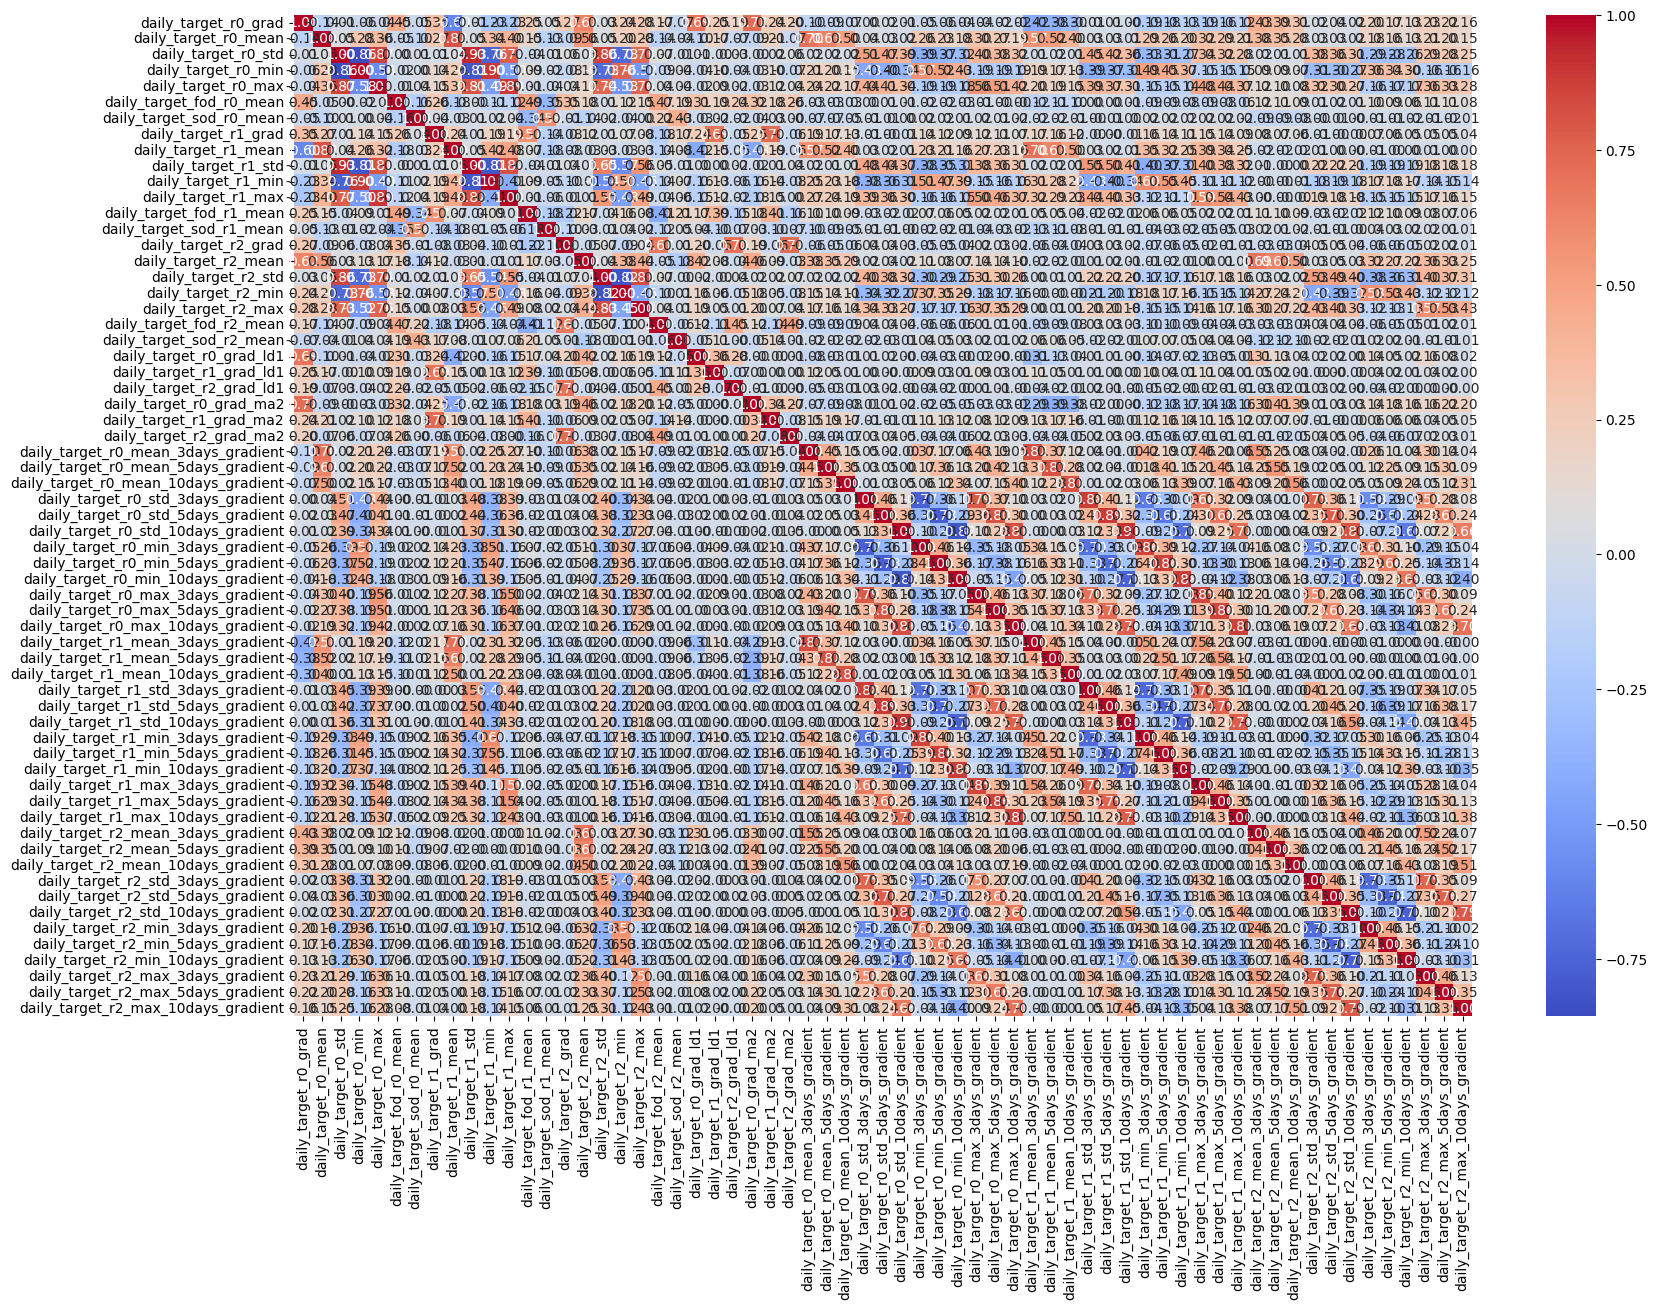

In [22]:
plot_heatmap(interday_target_features.corr(), figsize=(19, 13), annot=True, fmt=".2f")

## (Stock-Date) Interday Price Features

### Prepare Master Reference Dataframe
- To prepare the master dataframe for us to continue append when submitting via Kaggle kernel for test data
- Potentially can drop the rows which is too long ago (if we are just interested in past N days, then lag N + 1 can be throw like a queue to reduce memory)

In [90]:
%%time
daily_price_data = get_master_daily_price_data(master_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95236/95236 [00:02<00:00, 33755.48it/s]


CPU times: user 23.9 s, sys: 1.51 s, total: 25.4 s
Wall time: 25.4 s


### Main Processing

In [92]:
%%time
interday_price_features = generate_interday_price_features(daily_price_data, merge_gt=True)

Generating Interday gradient features...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.45s/it]


CPU times: user 5min 30s, sys: 1.5 s, total: 5min 32s
Wall time: 5min 31s


In [93]:
run_chi_square_tests(interday_price_features, target_col="daily_ground_truth_mean")

Feature: ref_price_r0_grad,                    χ^2 test stats: 1313, Useful
Feature: bid_price_r0_grad,                    χ^2 test stats: 1282, Useful
Feature: ask_price_r0_grad,                    χ^2 test stats: 1271, Useful
Feature: wa_price_r0_grad,                     χ^2 test stats: 1295, Useful
Feature: ref_price_r0_mean,                    χ^2 test stats: 1174, Useful
Feature: ref_price_r0_std,                     χ^2 test stats: 2577, Useful
Feature: ref_price_r0_min,                     χ^2 test stats: 1019, Useful
Feature: ref_price_r0_max,                     χ^2 test stats: 1183, Useful
Feature: ref_price_r0_last,                    χ^2 test stats: 1307, Useful
Feature: bid_price_r0_mean,                    χ^2 test stats: 1223, Useful
Feature: bid_price_r0_std,                     χ^2 test stats: 2546, Useful
Feature: bid_price_r0_min,                     χ^2 test stats: 1068, Useful
Feature: bid_price_r0_max,                     χ^2 test stats: 1205, Useful
Feature: bid

In [94]:
%%time
daily_price_data.to_parquet(f"{DATA_DIR}/optiver-features/stock_date_interday_price_table.parquet")
interday_price_features.to_parquet(f"{DATA_DIR}/optiver-features/stock_date_interday_price_features.parquet")

CPU times: user 1.03 s, sys: 62.9 ms, total: 1.09 s
Wall time: 1.02 s


In [95]:
# plot_heatmap(interday_price_features.iloc[:, :30].corr(), figsize=(19, 13), annot=True, fmt=".2f")

## (Stock-Date) Interday Volume Features

### Prepare Master Reference Dataframe
- To prepare the master dataframe for us to continue append when submitting via Kaggle kernel for test data
- Potentially can drop the rows which is too long ago (if we are just interested in past N days, then lag N + 1 can be throw like a queue to reduce memory)

In [97]:
daily_volume_data = get_master_daily_volume_data(master_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95236/95236 [00:02<00:00, 34799.98it/s]


### Main Processing

In [99]:
%%time
interday_volume_features = generate_interday_volume_features(daily_volume_data, merge_gt=True)

Generating Interday gradient features...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.45s/it]


CPU times: user 3min 25s, sys: 1.52 s, total: 3min 27s
Wall time: 3min 26s


In [100]:
run_chi_square_tests(interday_volume_features, target_col="daily_ground_truth_mean")

Feature: imb_size_r0_grad,                        χ^2 test stats: 598, Less Useful
Feature: matched_size_r0_grad,                    χ^2 test stats: 1482, Useful
Feature: imb_size_r0_mean,                        χ^2 test stats: 581, Less Useful
Feature: imb_size_r0_std,                         χ^2 test stats: 789, Less Useful
Feature: imb_size_r0_min,                         χ^2 test stats: 576, Less Useful
Feature: imb_size_r0_max,                         χ^2 test stats: 584, Less Useful
Feature: matched_size_r0_mean,                    χ^2 test stats: 1676, Useful
Feature: matched_size_r0_std,                     χ^2 test stats: 1456, Useful
Feature: matched_size_r0_min,                     χ^2 test stats: 1647, Useful
Feature: matched_size_r0_max,                     χ^2 test stats: 1583, Useful
Feature: imb_size_ld1_r0_mean,                    χ^2 test stats: 652, Less Useful
Feature: matched_size_ld1_r0_mean,                χ^2 test stats: 1470, Useful
Feature: imb_size_r1_grad,  

In [101]:
%%time
daily_volume_data.to_parquet(f"{DATA_DIR}/optiver-features/stock_date_interday_volume_table.parquet")
interday_volume_features.to_parquet(f"{DATA_DIR}/optiver-features/stock_date_interday_volume_features.parquet")

CPU times: user 613 ms, sys: 33.8 ms, total: 647 ms
Wall time: 612 ms
